In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Estimate TEOTIL2 source proportions by vassdragsområde

Reads TEOTIL2 results files and calculates nutrient flux proportions by source for a specified time period and range of vassdragsområder.

**This notebook uses a set of modified TEOTIL2 results files**, where discharges from selected wastewater sites that are already included in the Martini model have been removed (see the notebook [here](https://nbviewer.org/github/oslofjord-load-reductions/baseline-terrestrial-inputs/blob/main/notebooks/teotil2_remove_martini_ra.ipynb) for details). This means **the proportions shown below are not representative of the vassdragsområder overall**.

## 1. Read model results

In [2]:
# Period of interest
st_yr = 2015
end_yr = 2019

# Vassdragsområder of interest
vass_min = 1
vass_max = 25

# Folder containing model results files
data_fold = r"../data/teotil2_output_minus_martini_renseanlegg"

In [3]:
# Read model results for vassoms of interest
vassoms = [f"{i:03d}." for i in range(vass_min, vass_max + 1)]
df_list = []
for year in range(st_yr, end_yr + 1):
    csv_path = os.path.join(data_fold, f"teotil2_results_minus_martini_ra_{year}.csv")
    df = pd.read_csv(csv_path)
    df["year"] = year
    index_cols = ["regine", "regine_ned", "year", "vassom"]
    other_cols = [col for col in df.columns if col not in index_cols]
    df["vassom"] = df["regine"].str[:4]
    df = df[index_cols + other_cols]
    df = df.query("vassom in @vassoms").round(2)
    df_list.append(df)

# Combine
df = pd.concat(df_list)
df.sort_values(["regine", "year"], inplace=True)
vassom_df = df.query("regine in @vassoms")
del df["vassom"], vassom_df["vassom"]

## 2. Proportions by source

In [4]:
def proportions_by_source(vassom_df, pars, srcs):
    """For each vassdragsområde in 'vassom_df', estimate the percentage contribution from each
    source in 'srcs'.

    Args
        vassom_df: Dataframe. TEOTIL2 results for vassdragsområder of interest
        pars: List of str. Parameters to consider. One or more of ['tot-n', 'tot-p']
        srcs: List of str. Sources to consider. One or more of
            ["agri", "aqu", "ind", "nat-diff", "ren", "spr", "urban"]

    Returns
        Dataframe.
    """
    # Select columns of interest
    cols = ["regine", "year"] + [
        col for col in vassom_df.columns if col.startswith("accum")
    ]
    vassom_df = vassom_df[cols].copy()
    vassom_df.columns = [
        col.replace("nat_diff", "nat-diff") for col in vassom_df.columns
    ]

    # Combine point and diffuse from agri
    for par in pars:
        agri_cols = [f"accum_agri_diff_{par}_tonnes", f"accum_agri_pt_{par}_tonnes"]
        vassom_df[f"accum_agri_{par}_tonnes"] = vassom_df[agri_cols].sum(axis=1)
        vassom_df.drop(columns=agri_cols, inplace=True)

    # Calculate percentages for cols of interest
    for par in pars:
        for src in srcs:
            vassom_df[f"{src}_{par}_pct"] = (
                100
                * vassom_df[f"accum_{src}_{par}_tonnes"]
                / vassom_df[f"accum_all_sources_{par}_tonnes"]
            )

    # Select percentage columns
    cols = ["regine", "year"] + [
        col for col in vassom_df.columns if col.endswith("pct")
    ]
    vassom_df = vassom_df[cols]

    # Group by 'regine' and calculate mean
    vassom_df = vassom_df.groupby(["regine"]).mean(numeric_only=True).reset_index()
    del vassom_df["year"]

    # Melt dataframe and split 'variable' into 'source' and 'parameter'
    vassom_df = vassom_df.melt(id_vars="regine")
    vassom_df[["source", "parameter"]] = vassom_df["variable"].str.split(
        "_", n=2, expand=True
    )[[0, 1]]
    vassom_df.drop(columns="variable", inplace=True)

    # Rename 'value' to 'proportion_pct' and reorder columns
    vassom_df.rename({"value": "proportion_pct"}, axis="columns", inplace=True)
    vassom_df = vassom_df[["regine", "parameter", "source", "proportion_pct"]]

    # Sort dataframe
    vassom_df = vassom_df.sort_values(["regine", "parameter", "source"]).reset_index()

    return vassom_df


def plot_stacked_bar_charts(prop_df):
    """Create a stacked bar chart showing nutrient source proportion by vassdragsområde.

    Args
        prop_df: dataframe. As returned by 'proportions_by_source'

    Returns
        None. Plot is created.
    """
    # Pivot the DataFrame to get the data in the right format
    df_pivot = prop_df.pivot_table(
        index=["regine", "parameter"],
        columns="source",
        values="proportion_pct",
        fill_value=0,
    )

    # Get the list of parameters
    parameters = prop_df["parameter"].unique()

    # For each parameter, create a subplot
    for i, parameter in enumerate(parameters):
        plt.figure(i)
        df_subset = df_pivot.xs(parameter, level="parameter")
        ax = df_subset.plot(kind="bar", stacked=True, figsize=(8, 4))
        plt.title(parameter.upper())
        plt.ylabel("Proportion (%)")
        plt.xlabel("Vassdragsområde")
        plt.tight_layout()
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [5]:
# User input
pars = ["tot-n", "tot-p"]
srcs = ["agri", "aqu", "ind", "nat-diff", "ren", "spr", "urban"]
prop_csv = f"../data/vassom_props_by_src_minus_martini_ra_{st_yr}-{end_yr}.csv"

In [6]:
# Get proportions
prop_df = proportions_by_source(vassom_df, pars, srcs)
prop_df.to_csv(prop_csv, index=False)

prop_df.head(10)

,index,regine,parameter,source,proportion_pct
0,0,001.,tot-n,agri,43.696516
1,25,001.,tot-n,aqu,0.000000
2,50,001.,tot-n,ind,7.647211
3,75,001.,tot-n,nat-diff,40.943825
4,100,001.,tot-n,ren,3.746483
5,125,001.,tot-n,spr,3.333761
6,150,001.,tot-n,urban,0.632241
7,175,001.,tot-p,agri,39.302555
8,200,001.,tot-p,aqu,0.000000
9,225,001.,tot-p,ind,38.494057


Mean nutrient proportions by source and vassdragsområde from 2015 - 2019 (excluding wastewater sites already in the Martini model):


<Figure size 640x480 with 0 Axes>

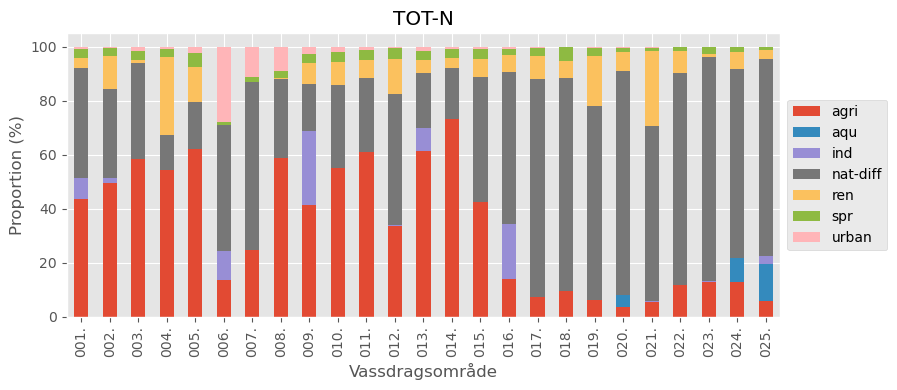

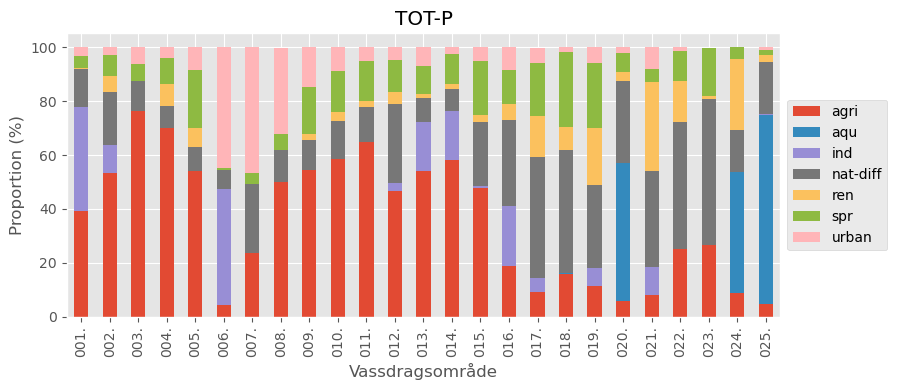

In [7]:
# Plot
print(f"Mean nutrient proportions by source and vassdragsområde from {st_yr} - {end_yr} (excluding wastewater sites already in the Martini model):")
plot_stacked_bar_charts(prop_df)